# 올리브영 브랜드 이미지 분석

뷰티제품 유통업계 선두주자로 파악되는 올리브영.
그 외 쿠팡 등 경쟁업체가 있지만, 올리브영만의 브랜드 이미지 파악하기.

#1. 데이터 불러오기

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (4,345 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126319 files and dire

In [ ]:
!fc-list :lang=ko

/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf: NanumSquareRound,나눔스퀘어라운드,NanumSquareRound Bold,나눔스퀘어라운드 Bold:style=Bold,Regular
/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf: NanumGothicCoding,나눔고딕코딩:style=Bold
/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf: NanumSquareRound,나눔스퀘어라운드,NanumSquareRound Regular,나눔스퀘어라운드 Regular:style=Regular
/usr/share/fonts/truetype/nanum/NanumSquareB.ttf: NanumSquare,나눔스퀘어,NanumSquare Bold,나눔스퀘어 Bold:style=Bold
/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf: NanumBarunGothic,나눔바른고딕:style=Regular
/usr/share/fonts/truetype/nanum/NanumGothic.ttf: NanumGothic,나눔고딕:style=Regular
/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf: NanumGothicCoding,나눔고딕코딩:style=Regular
/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf: NanumBarunGothic,나눔바른고딕:style=Bold
/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf: NanumGothic,나눔고딕:style=Bold
/usr/share/fonts/truetype/nanum/NanumSquareR.ttf: NanumSquare,나눔스퀘어:style=Regular
/us

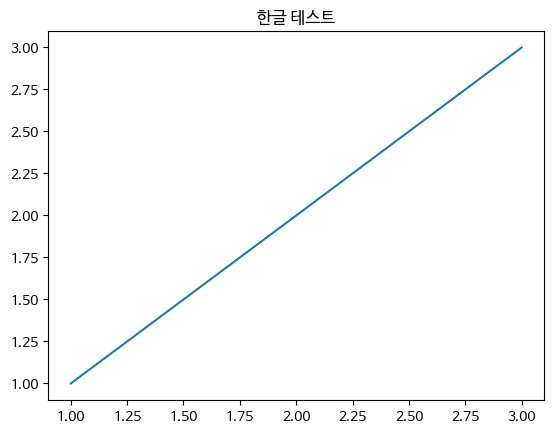

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.plot([1, 2, 3], [1, 2, 3])
plt.title("한글 테스트")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import Counter
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from mpl_toolkits.mplot3d import Axes3D

올리브영 랭킹 페이지에서 100개 데이터 가져오기

In [ ]:
# CSV 파일 읽기
df = pd.read_csv('/content/sample_data/oliveyoung_products.csv')

# 데이터 확인
print("데이터 크기:", df.shape)
print("\n처음 5개 행:")
print(df.head())

데이터 크기: (100, 9)

처음 5개 행:
    브랜드                                                상품명    현재가격      정가  \
0   빌리프  [6월올영픽/생기UP] 빌리프 슈퍼나이츠 멀티 비타민 마스크 75ml 단품/기획(7...  25,900  39,000   
1   어노브  [6월 올영픽/더블한정기획 출시] 어노브 딥 데미지 헤어 트리트먼트 EX 320ml...  29,800  42,000   
2   메디힐  [6월 올영픽/휴대용케이스 증정] 메디힐 네모 토너패드 100+100매 한정기획 (...  28,900  39,900   
3   메디힐   [6월 올영픽/31억장 돌파] 메디힐 에센셜 마스크팩 10/10+1매 고기능 7종 택1  10,000  20,000   
4  라운드랩       [6월 올영픽][1+1+1] 라운드랩 자작나무 수분 선크림 40ml 트리플 기획  25,900  30,000   

      쿠폰  무료배송    세일   사은품  순위  
0   True  True  True  True   1  
1  False  True  True  True   2  
2  False  True  True  True   3  
3  False  True  True  True   4  
4  False  True  True  True   5  


## 1. 카테고리 변수 추가

### 1. 수기로 카테고리 분류
올리브영 페이지 상세 카테고리 참고하여 아래와 같이 수기로 분류 시도하였으나, 기타로 분류되는 데이터가 상당히 많음

In [ ]:
general_category_keywords = {
    "스킨케어": [
        "스킨", "토너", "에센스", "세럼", "앰플", "크림", "로션", "미스트", "오일",
        "스킨케어세트", "마스크팩", "시트팩", "패드", "페이셜팩", "코팩", "패치"
    ],
    "클렌징": [
        "클렌징", "클렌저", "폼", "젤", "오일", "밤", "워터", "밀크", "필링", "스크럽",
        "티슈", "립리무버", "아이리무버", "클렌징기", "클렌징디바이스"
    ],
    "선케어": [
        "선크림", "선스틱", "선쿠션", "선스프레이", "선패치", "태닝", "애프터선"
    ],
    "메이크업": [
        "립스틱", "립틴트", "립밤", "립글로스", "파운데이션", "쿠션", "비비", "씨씨",
        "프라이머", "컨실러", "마스카라", "아이섀도우", "아이라이너", "브로우", "아이브로우", "틴트"
    ],
    "헤어케어": [
        "샴푸", "린스", "트리트먼트", "헤어팩", "두피앰플", "두피토닉", "헤어에센스",
        "염색약", "펌", "헤어드라이기", "고데기", "헤어브러시", "왁스", "스프레이", "무스"
    ],
    "바디케어": [
        "샤워젤", "입욕제", "바디워시", "바디로션", "바디오일", "바디미스트", "핸드크림",
        "핸드로션", "풋크림", "풋파일", "제모", "왁싱", "데오드란트", "선물세트"
    ],
    "향수/디퓨저": [
        "향수", "미니향수", "고체향수", "디퓨저", "향초", "홈프래그런스"
    ],
    "네일": [
        "네일폴리시", "매니큐어", "젤네일", "네일팁", "네일스티커", "네일리무버", "큐티클오일"
    ],
    "건강식품": [
        "비타민", "영양제", "유산균", "슬리밍", "이너뷰티"
    ],
    "푸드": [
        "식단관리", "과자", "초콜릿", "디저트", "생수", "음료", "커피", "간편식", "요리", "베이비푸드"
    ],
    "헬스/건강용품": [
        "패치", "국소케어", "릴랙스", "생활", "의료", "마사지", "보호대", "운동용품"
    ],
    "구강용품": [
        "칫솔", "치약", "애프터구강케어", "휴대용세트", "구강가전"
    ],
    "위생용품": [
        "생리", "위생용품", "Y존케어", "성인용품", "마사지젤", "테스트기", "성인용 기저귀", "화장지"
    ],
    "뷰티소품": [
        "브러쉬", "퍼프", "스펀지", "속눈썹", "아이테이프", "마스크브러쉬", "팩붓", "헤어밴드",
        "핀", "집게", "네일도구", "풋파일", "거울", "파우치"
    ]
}

def classify_general_category(product_name):
    for category, keywords in general_category_keywords.items():
        if any(keyword in str(product_name) for keyword in keywords):
            return category
    return "기타"

df['일반카테고리'] = df['상품명'].apply(classify_general_category)
print(df[['상품명', '일반카테고리']])


                                                  상품명 일반카테고리
0   [6월올영픽/생기UP] 빌리프 슈퍼나이츠 멀티 비타민 마스크 75ml 단품/기획(7...   건강식품
1   [6월 올영픽/더블한정기획 출시] 어노브 딥 데미지 헤어 트리트먼트 EX 320ml...   헤어케어
2   [6월 올영픽/휴대용케이스 증정] 메디힐 네모 토너패드 100+100매 한정기획 (...   스킨케어
3    [6월 올영픽/31억장 돌파] 메디힐 에센셜 마스크팩 10/10+1매 고기능 7종 택1   스킨케어
4        [6월 올영픽][1+1+1] 라운드랩 자작나무 수분 선크림 40ml 트리플 기획   스킨케어
..                                                ...    ...
95          [총 5매] 넘버즈인 1~5번 마스크팩 4매 (+1매 증정기획) 중 택 1   스킨케어
96                  [6월 올영픽/리필 기획] 클리오 킬브로우 오토하드브로우펜슬   메이크업
97              [NEW출시] 데이지크 섀도우팔레트 23 colors (단품/기획)     기타
98                [1위 다시마샴푸] 청미정 다시마 샴푸 500ml (단품/기획)   헤어케어
99      [NEW 쉬어 블러 스틱 증정] 웨이크메이크 소프트 블러링 아이팔레트(단품/기획)     기타

[100 rows x 2 columns]


In [ ]:
other_products = df[df['일반카테고리']=='기타']['상품명']
print(other_products)

24    [6월 올영픽][저자극/무기자차] 닥터지 그린 마일드 업 선 플러스 기획 2종 택 ...
30              [6월올영픽] 어반디케이 메이크업 세팅 픽서 트래블 30ml 더블 기획
31      [6/17 하루특가] [체취 개선] W.DRESSROOM 퍼펙트 데오 워시 500ml
33                      [NEW/이사배브랜드] 투슬래시포 올 오버 페이스 블러쉬
35                        딜라이트 프로젝트 단백질쉐이크 단품/7개입 8종 택1
37              [놓치면 끝][기획/단품]웨이크메이크 소프트 블러링 아이 팔레트 8컬러
42        [6월 올영픽/NEW컬러] 퓌 3D 볼류밍 글로스(30%/70%) 5.3g 17종
48             [뷰티디바이스 1위] 메디큐브 부스터프로/부스터프로 미니 기획세트 라인업
51    [6월 올영픽][보송톤업/파데프리] 닥터지 브라이트닝 업 선 플러스 기획 2종 택 ...
53                 [픽서 본품 증정] 어바웃톤 블러 파우더 팩트 6종 (기획/단품)
57                       [NEW컬러] 씨스터앤 퍼펙트 슬림 아이펜슬 7종 택1
58                       [6월올영픽] 영라뉴 장용성 파비플로라 PRO 14캡슐
62         [3시간팩] 바이오던스 리얼 딥 마스크 7매 (콜라겐, 세라놀, 비타, 씨켈프)
64                                 딜라이트 프로젝트 베이글칩 7종 택1
65         [6월올영픽/1위수상] 토리든 마스크 10매 기획 3종 (수분/진정/브라이트닝)
68    [뷰티디바이스 1위] [광채토닝 메디큐브 부스터프로 쿠로미 에디션(+쿠로미헤드캡+세...
71     [6월 올영픽][화잘먹/수분선] 닥터지 레드 블레미쉬 수딩 업 선 50ml 1+1 기획
76                  [6월 올영픽] 바이오더마 센시비오 H2O 500m

###2. LLM 활용하여 카테고리 분류
open ai 활용
- 아래 코드로 이미 LLM으로 분류하였으므로 아래 csv 파일 활용해서 다음 분석 코드 진행할 것


In [ ]:
# 일반 카테고리 후보 정의
category_candidates = [
    "스킨케어", "클렌징", "선케어", "메이크업", "헤어케어", "바디케어",
    "건강식품/푸드", "위생용품", "기타"
]

def classify_category_llm(product_name):
    prompt = f"""아래 상품명을 보고 카테고리 후보 중 가장 적합한 카테고리 하나만 골라줘.
카테고리 후보: {', '.join(category_candidates)}
- 상품명: {product_name}
정확히 하나의 카테고리만 답변해줘."""
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=10,
            temperature=0
        )
        # 최신 응답 구조에 맞게 파싱
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error: {e}")
        return "기타"

# LLM 분류 적용 (대량 처리 시 sleep 권장)
df['일반카테고리'] = df['상품명'].apply(lambda x: classify_category_llm(x))
    # time.sleep(1)  # 대량 분류 시 과금/속도 이슈로 sleep 권장

print(df[['상품명', '일반카테고리']].head())

# 결과를 CSV 파일로 저장
df.to_csv('oliveyoung_products_categorized.csv', index=False, encoding='utf-8-sig')
print("분류된 데이터가 'oliveyoung_products_categorized.csv' 파일로 저장되었습니다.")

#2. EDA

In [ ]:
# CSV 파일 읽기
df = pd.read_csv('/content/oliveyoung_products_categorized.csv')
df.head()

,브랜드,상품명,현재가격,정가,쿠폰,무료배송,세일,사은품,순위,일반카테고리
0,빌리프,[6월올영픽/생기UP] 빌리프 슈퍼나이츠 멀티 비타민 마스크 75ml 단품/기획(7...,"25,900","39,000",True,True,True,True,1,스킨케어
1,어노브,[6월 올영픽/더블한정기획 출시] 어노브 딥 데미지 헤어 트리트먼트 EX 320ml...,"29,800","42,000",False,True,True,True,2,헤어케어
2,메디힐,[6월 올영픽/휴대용케이스 증정] 메디힐 네모 토너패드 100+100매 한정기획 (...,"28,900","39,900",False,True,True,True,3,스킨케어
3,메디힐,[6월 올영픽/31억장 돌파] 메디힐 에센셜 마스크팩 10/10+1매 고기능 7종 택1,"10,000","20,000",False,True,True,True,4,스킨케어
4,라운드랩,[6월 올영픽][1+1+1] 라운드랩 자작나무 수분 선크림 40ml 트리플 기획,"25,900","30,000",False,True,True,True,5,선케어


In [ ]:
# 순서 변경 및 변수명 변경
df = df[['브랜드', '상품명', '현재가격', '정가', '쿠폰', '무료배송', '세일', '사은품', '일반카테고리']]
df = df.rename(columns={'일반카테고리': '카테고리'})

In [ ]:
## 아래 분석하다가 나온 오류 데이터 수정

# 디어스킨 에어쿨링 데이터를 위생용품 카테고리로 재분류
df.loc[df['상품명'].str.contains('디어스킨.*에어쿨링', na=False), '카테고리'] = '위생용품'

# 메디힐 위생용품 데이터를 스킨케어로 재분류
df.loc[df['브랜드'].str.contains('메디힐', na=False) & (df['카테고리'] == '위생용품'), '카테고리'] = '스킨케어'


##1. 상품 카테고리

In [ ]:
# 카테고리별 상품 수 확인
category_counts = df['카테고리'].value_counts()
print("카테고리별 상품 수:")
print(category_counts)

카테고리별 상품 수:
카테고리
스킨케어     38
메이크업     23
선케어      14
건강식품/     8
헤어케어      7
위생용품      4
클렌징       3
바디케어      3
Name: count, dtype: int64


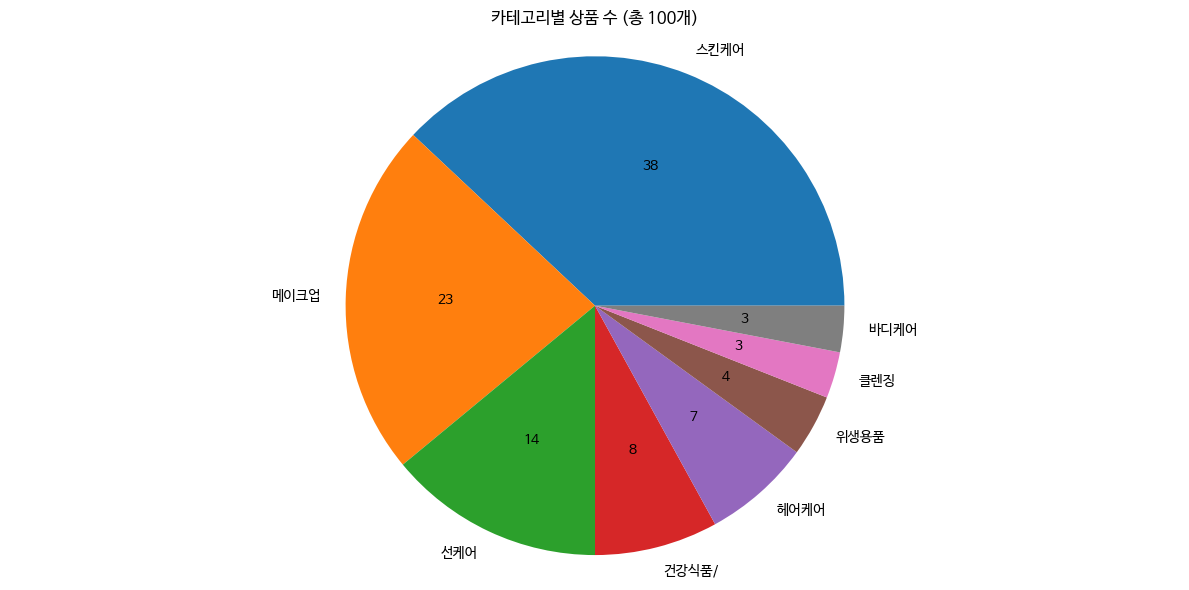

In [ ]:
# 카테고리별 상품 수 시각화
plt.figure(figsize=(12, 6))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%d')
plt.title('카테고리별 상품 수 (총 100개)')
plt.axis('equal')  # 원형 그래프를 완벽한 원으로 표시
plt.tight_layout()
plt.show()

# 스킨케어 가장 많음.
# 올리브영 판매량에서 스킨케어가 높은 것은 기초 피부에 바르는 만큼.
# 소비자가 해당 제품의 효과, 안전성, 성분, 브랜드의 진정성에 대해 신뢰를 갖고 있음 보여줌.
# 온라인 플랫폼인 쿠팡은 메이크업 제품이 많은 데 비해, 온+오프라인을 가진 올리브영이 가진 장점을 보여줌

# 100개 제품 중 스킨케어 제외하고도 선케어 제품이 약 15%가량 차지하는 것 또한 계절적 요소가 잘 반영되어 있음을 보여줌


In [ ]:
# 카테고리별 상품 수의 전체 합 계산
total_products = category_counts.sum()
print(f"전체 상품 수: {total_products}")

전체 상품 수: 100


##2. 세일상품 분석

In [ ]:
# 세일이 아닌 데이터 중 정가와 현재가격이 다른 데이터 존재
non_sale_products = df[df['세일'] == False]
price_diff_products = non_sale_products[non_sale_products['현재가격'] != non_sale_products['정가']]

print("\n세일이 아닌데 가격이 다른 상품:")
print(price_diff_products[['상품명', '현재가격', '정가', '세일', '카테고리']])

# 가격이 다른 상품을 세일로 변경
df.loc[price_diff_products.index, '세일'] = True


세일이 아닌데 가격이 다른 상품:
                                                  상품명    현재가격      정가     세일  \
8                      [온라인단독] 딜라이트 프로젝트 베이글칩 5입 선물세트   8,900  13,000  False   
10                     [히또핏X락티브] 미오이노시톨+여성유산균 1/4/8개월  30,900  51,500  False   
35                      딜라이트 프로젝트 단백질쉐이크 단품/7개입 8종 택1   3,510   3,900  False   
53               [픽서 본품 증정] 어바웃톤 블러 파우더 팩트 6종 (기획/단품)  11,200  14,000  False   
54                    [혜임Pick] 디어스킨 에어쿨링 2종 택1(중형/대형)   6,300   8,400  False   
83                 [2025 New] 좋은느낌 썸머에디션 생리대 (패드/입오버)   7,200   9,000  False   
84  라로슈포제 시카플라스트 멀티 리페어 크림 B5 100ml 기획 (+멜라B3 세럼 3...  40,000  50,000  False   

     카테고리  
8   건강식품/  
10  건강식품/  
35  건강식품/  
53   메이크업  
54   위생용품  
83   위생용품  
84   스킨케어  


In [ ]:
# 카테고리별 세일 상품 비율
category_sale_ratio = df.groupby('카테고리')['세일'].mean() * 100
print("카테고리별 세일 상품 비율(%):")
print(category_sale_ratio.round(2))
# 대부분 제품 세일진행 : 신규고객들의 첫 구매 유도 등 효과적..

카테고리별 세일 상품 비율(%):
카테고리
건강식품/     75.00
메이크업      95.65
바디케어     100.00
선케어       92.86
스킨케어     100.00
위생용품     100.00
클렌징      100.00
헤어케어      85.71
Name: 세일, dtype: float64


In [ ]:
# 세일이 아닌 상품 데이터 분석
df[df['세일'] == False]

,브랜드,상품명,현재가격,정가,쿠폰,무료배송,세일,사은품,카테고리
9,밀잇,[6월 올영PICK] 밀잇 식단관리 단백질쉐이크 40g 5종 택1,"3,900","3,900",False,True,False,False,건강식품/
19,한스킨,[안다PICK] 한스킨 코드온 디디 크림 파운데이션 35ml 5Colors (브러쉬...,"30,000","30,000",False,False,False,False,메이크업
64,딜라이트 프로젝트,딜라이트 프로젝트 베이글칩 7종 택1,"2,700","2,700",False,True,False,False,건강식품/
74,릴리이브,[아름송이 PICK] 릴리이브 그로우턴 탈모 브러쉬 앰플 100ml 기획 (+100...,"39,800","39,800",False,True,False,False,헤어케어
81,토코보,[1+1] 토코보 코튼 소프트 선스틱 19g SPF50+ PA++++,"22,000","22,000",False,True,False,False,선케어


##3. 상품 브랜드

In [ ]:
# 브랜드 수 계산
brand_count = df['브랜드'].nunique()
print(f"총 브랜드 수: {brand_count}")

## 100개 랭킹 내 브랜드가 약 70개 차지
# 다양한 브랜드가 분포되어 있어 뷰티시장 내 브랜드 경쟁이 높고, 소비자의 다양한 선택이 가능
# 소비자들이 브랜드 충성도보다는 제품의 기능, 성분, 트렌드, 가성비 등 다양한 기준으로 상품을 선택함.

총 브랜드 수: 69


In [ ]:
# 브랜드별 상품 수 확인
brand_counts = df['브랜드'].value_counts()
print("\n브랜드별 상품 수:")
print(brand_counts)


브랜드별 상품 수:
브랜드
메디힐      6
닥터지      6
라운드랩     3
바이오더마    3
어노브      3
        ..
에스쁘아     1
트리헛      1
넘버즈인     1
데이지크     1
청미정      1
Name: count, Length: 69, dtype: int64


In [ ]:
# 상위 5개 브랜드 추출
top_5_brands = brand_counts.head(5).index

# 전체 카테고리 리스트 정의 (혹은 df['카테고리'].unique()로 자동 추출)
all_categories = df['카테고리'].unique()
brand_category_matrix = pd.DataFrame(index=all_categories)

for brand in top_5_brands:
    brand_products = df[df['브랜드'] == brand]
    category_distribution = brand_products['카테고리'].value_counts()
    brand_category_matrix[brand] = category_distribution.reindex(all_categories, fill_value=0)

# 모든 값이 0인 행(카테고리) 제거
brand_category_matrix = brand_category_matrix.loc[brand_category_matrix.sum(axis=1) != 0]

brand_category_matrix.astype(int)

,메디힐,닥터지,라운드랩,바이오더마,어노브
스킨케어,6,3,0,3,0
헤어케어,0,0,0,0,3
선케어,0,3,3,0,0


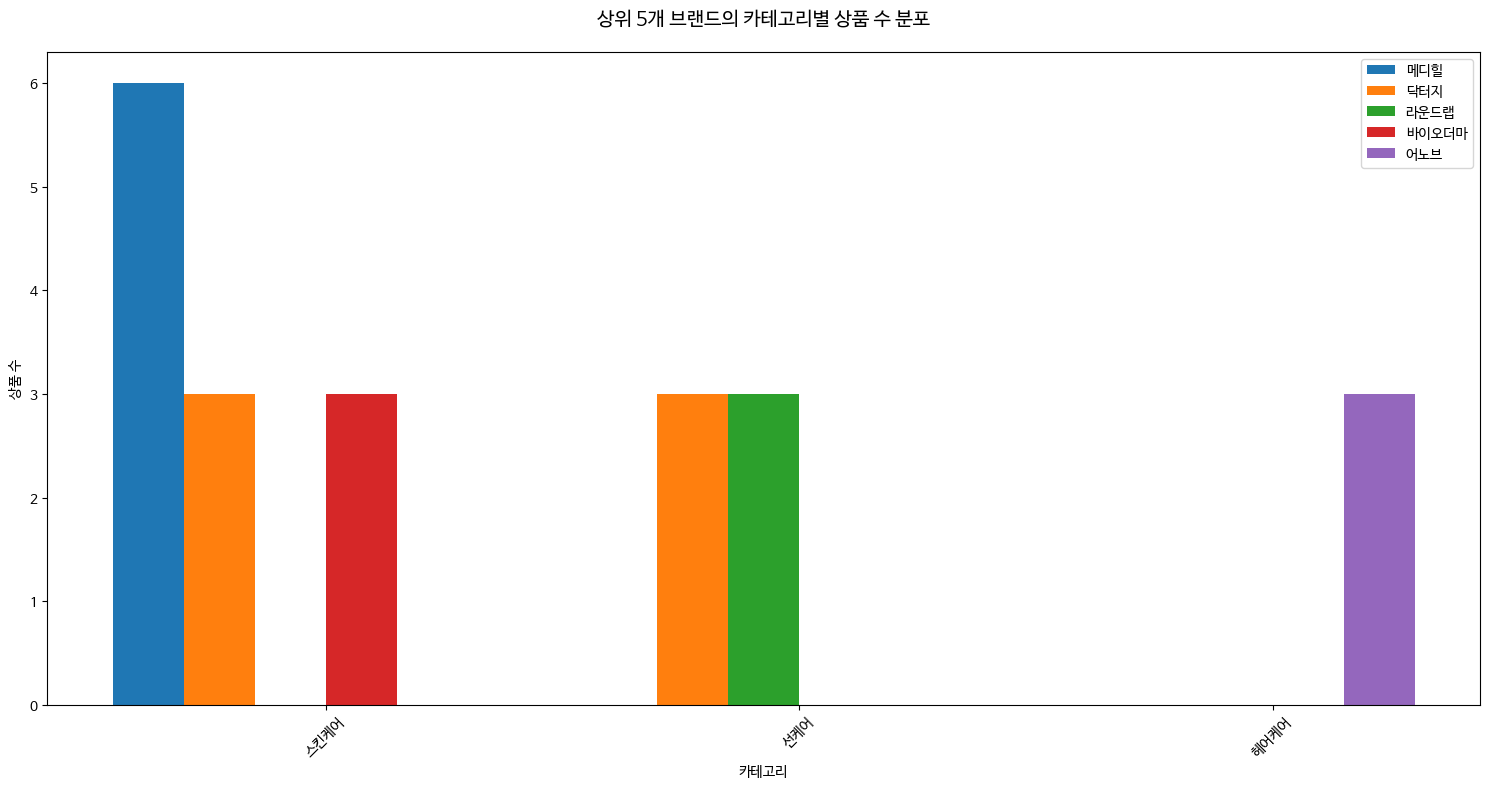

In [ ]:
# top_5_brands 리스트가 있다고 가정
category_totals = {}

for brand in top_5_brands:
    brand_products = df[df['브랜드'] == brand]
    category_distribution = brand_products['카테고리'].value_counts()
    for cat, count in category_distribution.items():
        category_totals[cat] = category_totals.get(cat, 0) + count

# 0이 아닌 카테고리만 추출
categories = [cat for cat, total in category_totals.items() if total > 0]
x = np.arange(len(categories))

plt.figure(figsize=(15, 8))
colors = ['#A8D5BA', '#F9D5A7', '#F7A072', '#FFB7B2', '#B5EAD0']

for i, brand in enumerate(top_5_brands):
    brand_products = df[df['브랜드'] == brand]
    category_distribution = brand_products['카테고리'].value_counts()
    width = 0.15
    offset = (i - len(top_5_brands)/2) * width
    plt.bar(
        x + offset,
        [category_distribution.get(cat, 0) for cat in categories],
        width=width,
        label=brand,
    )

plt.title('상위 5개 브랜드의 카테고리별 상품 수 분포', fontsize=14, pad=20)
plt.xlabel('카테고리')
plt.ylabel('상품 수')
plt.xticks(x, categories, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 현재가격을 숫자형으로 변환 (쉼표 제거 후 정수형으로 변환)
df['현재가격_숫자'] = df['현재가격'].str.replace(',', '').astype(int)

# 현재가격 기준으로 내림차순 정렬
sorted_by_price = df.sort_values('현재가격_숫자', ascending=False)

# 정렬된 결과 출력 (상위 10개)
print("\n현재가격 기준 상위 10개 상품:")
print(sorted_by_price[['브랜드', '상품명', '현재가격', '정가']].head(10))


현재가격 기준 상위 10개 상품:
          브랜드                                                상품명     현재가격  \
68  메디큐브 에이지알  [뷰티디바이스 1위] [광채토닝 메디큐브 부스터프로 쿠로미 에디션(+쿠로미헤드캡+세...  349,000   
48  메디큐브 에이지알           [뷰티디바이스 1위] 메디큐브 부스터프로/부스터프로 미니 기획세트 라인업   97,000   
84      라로슈포제  라로슈포제 시카플라스트 멀티 리페어 크림 B5 100ml 기획 (+멜라B3 세럼 3...   40,000   
74       릴리이브  [아름송이 PICK] 릴리이브 그로우턴 탈모 브러쉬 앰플 100ml 기획 (+100...   39,800   
73        포맨트       [1위향수/한정판]포맨트 시그니처 퍼퓸/헤어퍼퓸 헬로키티 에디션/단품 3종 택1   36,900   
63         달바             [베이스착붙] 달바 핑크 톤업 선크림 듀오 기획 (50ml+50ml)   35,700   
56         달바            [NO.1 미스트세럼] 달바 퍼스트 스프레이 세럼 100ml 2개 기획   35,200   
44      라로슈포제  라로슈포제 시카플라스트 밤 B5+ 100ml 기획 (+히알루 B5 세럼 1.5ml*...   32,400   
10        락티브                     [히또핏X락티브] 미오이노시톨+여성유산균 1/4/8개월   30,900   
76      바이오더마                [6월 올영픽] 바이오더마 센시비오 H2O 500ml 2입 기획   30,300   

         정가  
68  418,800  
48   99,000  
84   50,000  
74   39,800  
73   39,000  
63   51,000  
56   59,800  
44   40,000  
10   5

#3. 메이크업 카테고리 텍스트 분석

In [ ]:
# 메이크업 카테고리 제품만 필터링
makeup_products = df[df['카테고리'] == '메이크업']

# 메이크업 제품 정보 출력 (가격 내림차순 정렬)
print(f"\n메이크업 카테고리 제품 (가격 높은순) - 총 {len(makeup_products)}개:")
makeup_products_sorted = makeup_products.sort_values('현재가격_숫자', ascending=False)
print(makeup_products_sorted[['브랜드', '상품명', '현재가격', '정가']])


메이크업 카테고리 제품 (가격 높은순) - 총 23개:
       브랜드                                                상품명    현재가격      정가
73     포맨트       [1위향수/한정판]포맨트 시그니처 퍼퓸/헤어퍼퓸 헬로키티 에디션/단품 3종 택1  36,900  39,000
92    에스쁘아  [디즈니 콜라보/6월 올영픽] 에스쁘아 비벨벳 커버쿠션 SPF42 PA++ (본품+...  30,300  40,000
19     한스킨  [안다PICK] 한스킨 코드온 디디 크림 파운데이션 35ml 5Colors (브러쉬...  30,000  30,000
91     VDL  [6월올영픽/여름NEW] VDL 커버스테인 하이커버 쿠션 13g 기획(+리필+모공 ...  27,880  34,000
67     VDL     [6월올영픽/1등쿠션] VDL 커버 스테인 퍼펙팅 쿠션 기획(+미니 프라이머 증정)  27,880  34,000
97    데이지크              [NEW출시] 데이지크 섀도우팔레트 23 colors (단품/기획)  27,460  34,000
66     네이밍          [6월 올영픽] 네이밍 레이어드 핏 쿠션 기획(본품+리필+하이라이터 증정)  27,200  34,000
30   어반디케이            [6월올영픽] 어반디케이 메이크업 세팅 픽서 트래블 30ml 더블 기획  26,000  50,000
99  웨이크메이크      [NEW 쉬어 블러 스틱 증정] 웨이크메이크 소프트 블러링 아이팔레트(단품/기획)  23,800  34,000
90     오아드                         [미니립오일증정] 오아드 립티크 9종 단품/기획  23,400  26,000
33   투슬래시포                    [NEW/이사배브랜드] 투슬래시포 올 오버 페이스 블러쉬  22,500  25,000
55     키스미  [6월 올영픽][1+1] 키스미 스무

In [ ]:
# 메이크업 카테고리의 브랜드별 상품 수 확인
makeup_brand_counts = makeup_products['브랜드'].value_counts()
print(f"메이크업 카테고리 전체 브랜드 수: {len(makeup_brand_counts)}개")
print("\n메이크업 카테고리 브랜드별 상품 수:")
print(makeup_brand_counts)

메이크업 카테고리 전체 브랜드 수: 19개

메이크업 카테고리 브랜드별 상품 수:
브랜드
클리오       2
웨이크메이크    2
네이밍       2
VDL       2
어반디케이     1
롬앤        1
한스킨       1
퓌         1
어바웃톤      1
키스미       1
투슬래시포     1
씨스터앤      1
페리페라      1
무지개맨션     1
포맨트       1
투쿨포스쿨     1
오아드       1
에스쁘아      1
데이지크      1
Name: count, dtype: int64


In [ ]:
# 메이크업 카테고리 제품만 필터링
skincare_products = df[df['카테고리'] == '스킨케어']

# 메이크업 제품 정보 출력 (가격 내림차순 정렬)
print(f"\n메이크업 카테고리 제품 (가격 높은순) - 총 {len(skincare_products)}개:")
skincare_products_sorted = skincare_products.sort_values('현재가격_숫자', ascending=False)
print(skincare_products_sorted[['브랜드', '상품명', '현재가격']])


메이크업 카테고리 제품 (가격 높은순) - 총 38개:
          브랜드                                                상품명     현재가격
68  메디큐브 에이지알  [뷰티디바이스 1위] [광채토닝 메디큐브 부스터프로 쿠로미 에디션(+쿠로미헤드캡+세...  349,000
48  메디큐브 에이지알           [뷰티디바이스 1위] 메디큐브 부스터프로/부스터프로 미니 기획세트 라인업   97,000
84      라로슈포제  라로슈포제 시카플라스트 멀티 리페어 크림 B5 100ml 기획 (+멜라B3 세럼 3...   40,000
56         달바            [NO.1 미스트세럼] 달바 퍼스트 스프레이 세럼 100ml 2개 기획   35,200
44      라로슈포제  라로슈포제 시카플라스트 밤 B5+ 100ml 기획 (+히알루 B5 세럼 1.5ml*...   32,400
76      바이오더마                [6월 올영픽] 바이오더마 센시비오 H2O 500ml 2입 기획   30,300
22        웰라쥬      [대용량150ml] 웰라쥬 리얼 히알루로닉 블루 100 앰플 75ml 1+1 기획   29,900
62      바이오던스       [3시간팩] 바이오던스 리얼 딥 마스크 7매 (콜라겐, 세라놀, 비타, 씨켈프)   29,900
60        넛세린                 [이민정 PICK]넛세린 아로마 넛 슬림핏 괄사 세럼 60ml   29,500
89        토리든  [6월올영픽] 토리든 다이브인 히알루론산 수딩 크림 100ml 더블 한정 기획 (+...   29,400
16        메디힐         [58관왕/200매] 메디힐 네모패드 100+100매 더블기획 6종 골라담기   28,900
2         메디힐  [6월 올영픽/휴대용케이스 증정] 메디힐 네모 토너패드 100+100매 한정기획 (...   28,900
11    

In [ ]:
def normalize_olyoung_pick(text):
    # "6월 올영픽", "6월올영픽", "6월  올영픽" 모두 "6월올영픽"으로 변환
    return re.sub(r'6월\s*올영픽', '6월올영픽', text)

# 적용 예시
df['상품명'] = df['상품명'].apply(normalize_olyoung_pick)

In [ ]:
# 텍스트 빈도 분석
# 상품명 컬럼에서 한글 단어만 추출
def extract_korean_words(text):
    return re.findall(r'[가-힣]{2,}', str(text))

# 스킨케어 카테고리만 필터링
skincare_products = df[df['카테고리'] == '스킨케어']

all_words = []
for name in skincare_products['상품명']:
    all_words.extend(extract_korean_words(name))

word_counts = Counter(all_words)
top_keywords = word_counts.most_common(30)
print("\n스킨케어 카테고리 상품명 키워드 빈도 (상위 30개):")
print(top_keywords)


스킨케어 카테고리 상품명 키워드 빈도 (상위 30개):
[('기획', 16), ('월올영픽', 13), ('세럼', 7), ('증정', 6), ('메디힐', 6), ('크림', 4), ('마스크', 3), ('단품', 3), ('마스크팩', 3), ('바이오더마', 3), ('토너', 3), ('브링그린', 3), ('리필', 3), ('닥터지', 3), ('앰플', 3), ('더블기획', 3), ('토리든', 3), ('패드', 3), ('메디큐브', 3), ('부스터프로', 3), ('멀티', 2), ('마데카소사이드', 2), ('에센셜', 2), ('고기능', 2), ('하이드라비오', 2), ('등세럼', 2), ('징크테카', 2), ('레드', 2), ('블레미쉬', 2), ('클리어', 2)]


In [ ]:
# 텍스트 빈도 분석
# 상품명 컬럼에서 한글 단어만 추출
def extract_korean_words(text):
    return re.findall(r'[가-힣]{2,}', str(text))

# 스킨케어 카테고리만 필터링
skincare_products = df[df['카테고리'] == '메이크업']

all_words = []
for name in skincare_products['상품명']:
    all_words.extend(extract_korean_words(name))

word_counts = Counter(all_words)
top_keywords = word_counts.most_common(30)
print("\n메이크업 카테고리 상품명 키워드 빈도 (상위 30개):")
print(top_keywords)


메이크업 카테고리 상품명 키워드 빈도 (상위 30개):
[('기획', 13), ('단품', 10), ('월올영픽', 10), ('증정', 5), ('리필', 4), ('컬러', 3), ('본품', 3), ('쿠션', 3), ('틴트', 2), ('픽서', 2), ('네이밍', 2), ('웨이크메이크', 2), ('소프트', 2), ('블러링', 2), ('클리오', 2), ('블러', 2), ('틴뚜링', 1), ('증정기획', 1), ('롬앤', 1), ('쥬시', 1), ('래스팅', 1), ('안다', 1), ('한스킨', 1), ('코드온', 1), ('디디', 1), ('크림', 1), ('파운데이션', 1), ('브러쉬기획', 1), ('어반디케이', 1), ('메이크업', 1)]


#4. 군집분석

In [ ]:
# 카테고리를 원-핫 인코딩으로 변환
category_dummies = pd.get_dummies(df['카테고리'])

# 세일비율 계산 (정가 대비 현재가격)
df['세일비율'] = (1-(df['현재가격_숫자'] / df['정가'].str.replace(',', '').astype(int))) * 100

# 분석에 사용할 특성 선택
features = pd.concat([df['현재가격_숫자'], df['세일비율'], category_dummies], axis=1)

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# K-means 군집화 수행
kmeans = KMeans(n_clusters=5, random_state=42)
df['군집'] = kmeans.fit_predict(X_scaled)

# 군집별 특성 분석
cluster_analysis = df.groupby('군집').agg({
    '현재가격_숫자': ['mean', 'count'],
    '세일비율': 'mean',
    '카테고리': lambda x: x.value_counts().index[0]  # 가장 많은 카테고리
}).round(2)

print("\n군집별 특성 분석:")
print(cluster_analysis)


군집별 특성 분석:
     현재가격_숫자         세일비율     카테고리
        mean count   mean <lambda>
군집                                
0    7075.00     4  36.46     위생용품
1   32700.71    42  31.79     스킨케어
2   20781.43    14  22.29      선케어
3   17803.94    33  21.05     메이크업
4   28317.14     7  16.14     헤어케어


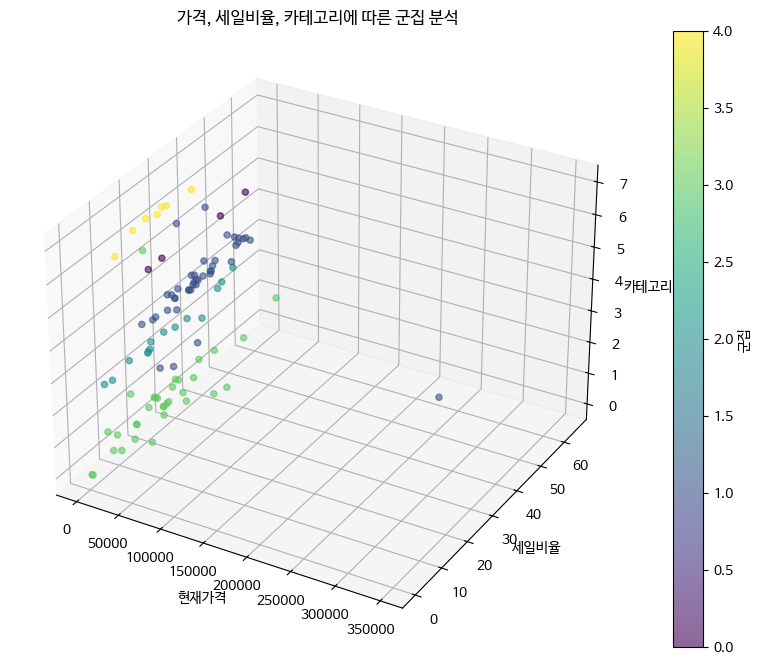

In [ ]:
# 3D 시각화
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df['현재가격_숫자'],
                    df['세일비율'],
                    df['카테고리'].astype('category').cat.codes,
                    c=df['군집'],
                    cmap='viridis',
                    alpha=0.6)

ax.set_xlabel('현재가격')
ax.set_ylabel('세일비율')
ax.set_zlabel('카테고리')
plt.title('가격, 세일비율, 카테고리에 따른 군집 분석')
plt.colorbar(scatter, label='군집')
plt.show()

In [ ]:
# 군집별 카테고리 분포
cluster_category = pd.crosstab(df['군집'], df['카테고리'])
print("\n군집별 카테고리 분포:")
cluster_category


군집별 카테고리 분포:


카테고리,건강식품/,메이크업,바디케어,선케어,스킨케어,위생용품,클렌징,헤어케어
군집,,,,,,,,
0,0,0,0,0,0,4,0,0
1,0,0,2,0,38,0,2,0
2,0,0,0,14,0,0,0,0
3,8,23,1,0,0,0,1,0
4,0,0,0,0,0,0,0,7


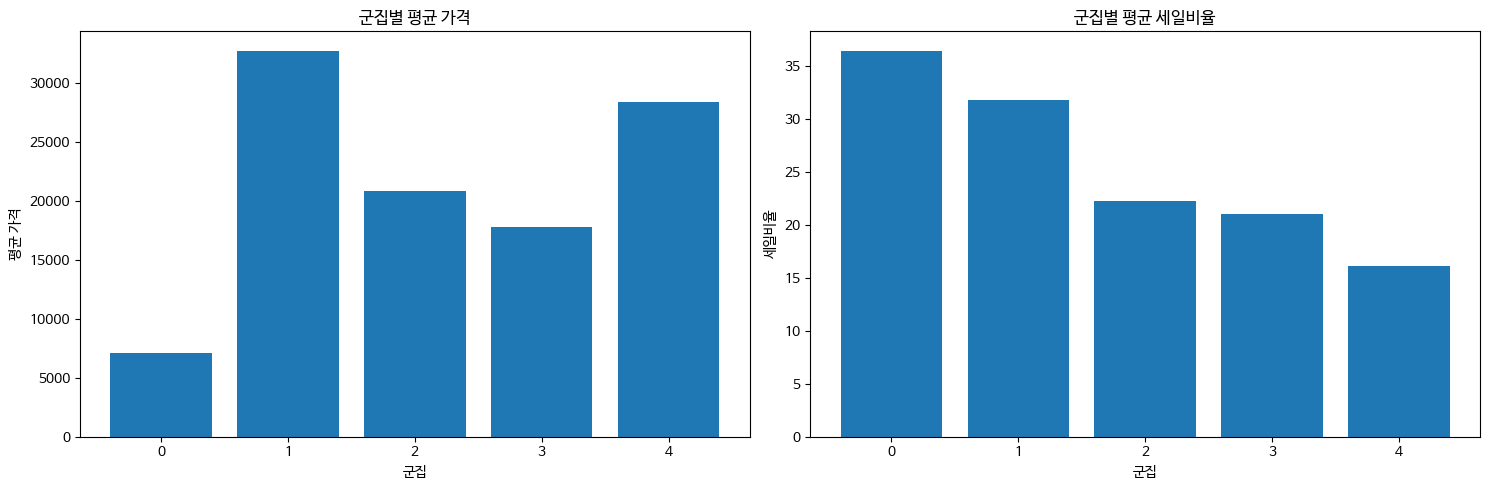

In [ ]:
# 군집별 평균 가격과 세일비율 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 평균 가격
cluster_price = df.groupby('군집')['현재가격_숫자'].mean()
ax1.bar(cluster_price.index, cluster_price.values)
ax1.set_title('군집별 평균 가격')
ax1.set_xlabel('군집')
ax1.set_ylabel('평균 가격')

# 평균 세일비율
cluster_sale = df.groupby('군집')['세일비율'].mean()
ax2.bar(cluster_sale.index, cluster_sale.values)
ax2.set_title('군집별 평균 세일비율')
ax2.set_xlabel('군집')
ax2.set_ylabel('세일비율')

plt.tight_layout()
plt.show()